# Applied Machine Learning Systems (MLS-1) - ELEC0134

# Final Assignment - Classification of Tumours

## Task A - Binary Classification using Support Vector Machines (SVM)

## Completed by Student Number - 18014580

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is a Jupyter Notebook submitted as part of the final assignment for the Applied Machine Learning Systems (MLS-1) coursework which involves tumor classification and identification.

This particular notebook tests the SVM method using the SVC model from the sklearn library on Task A to find the accuracy of using support vector machines classification for this particular task.

### Importing different packages

Initially, we must import the different packages needed for this task. The packages required to implement suport vector machines for this binary task can be found in pandas, sklearn (scikit-learn), skimage (scikit-image), and numpy. Please ensure these are installed in your virtualenv before running this code.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage import io
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import hog

# import tensorflow as tf
#from keras.preprocessing import image
import matplotlib.pyplot as plt

import os
from os import listdir

import seaborn as sns

from datetime import datetime

print("All imports carried out successfully")

All imports carried out successfully


In [3]:
#Starting time for code

taskB_start = datetime.now()

### Loading the data from the data sets

In this cell we are using read_csv to load the labels for each image into a dataframe. We then display the dataframe to ensure the data from the .csv file was loaded correctly.

Comment out the Google Drive path and uncomment the Jupyter path when running on Notebook (not Colab) as the dataset and test files will be in the same directory as the .ipynb files when downloaded from the GitHub repo. 

Ensure the folders "set" and "dataset" are in the same folder as the Notebook before running it.


In [4]:
#Loading the CSV file 'label' containing the different labels for each MRI Scan

#Used this path while running on Google Colab for accelerated GPU
label_path_GDrive = '/content/drive/MyDrive/Colab Notebooks/dataset/label.csv'

#Used this path when running regularly on Jupyter Notebook from repository
label_path_Jupyter = '.dataset/label.csv'

tumour_labels = pd.read_csv(label_path_GDrive)
#tumour_labels = pd.read_csv(label_path_Jupyter)

print(tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(3000, 2)


In [5]:
tumour_labels #Displaying data frame to visually ensure data loaded correctly

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,meningioma_tumor
2997,IMAGE_2997.jpg,glioma_tumor
2998,IMAGE_2998.jpg,glioma_tumor


### Adding numeric representation to the data frame

This is a multiclass classification task, so we cannot modify the labels as we did in Task A, as we now want to know the type of tumor not just if a tumor is present. However, we can add a column to the data frame and assign a numeric label to each image based on the type of tumor. 

In this case, we assign values from 0 to 3:
- no_tumour is assigned 0
- pituitary_tumor is assigned 1
- glioma_tumor is assigned 2 
- meningioma_tumor is assigned 3

Assigning numeric labels increases adaptability and convenience of the code, whether to later run deep learning models or for the SVM itself it would be easier if the labels were numeric.

In [6]:
#Loop through and assign each type of tumor a numeric label dependent on the index of the text it matchesin the list called classes

classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']
for CLASS in classes:
    tumour_labels.loc[tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [7]:
tumour_labels #Displaying dataframe to ensure new column created and values are being assigned properly

,file_name,label,numeric label
0,IMAGE_0000.jpg,meningioma_tumor,3.0
1,IMAGE_0001.jpg,no_tumor,0.0
2,IMAGE_0002.jpg,meningioma_tumor,3.0
3,IMAGE_0003.jpg,glioma_tumor,2.0
4,IMAGE_0004.jpg,meningioma_tumor,3.0
...,...,...,...
2995,IMAGE_2995.jpg,no_tumor,0.0
2996,IMAGE_2996.jpg,meningioma_tumor,3.0
2997,IMAGE_2997.jpg,glioma_tumor,2.0
2998,IMAGE_2998.jpg,glioma_tumor,2.0


### Choosing mode and loading the images

In the cell below, we load the image files using the imread functions from the scikit-image package. We convert the images to grayscale as a form of preprocessing. 

The images (whether grayscale or not) numpy arrays before appending them to a list. This list of arrays is then converted to a numpy array of arrays to allow us to print the shape to verify all the images have been loaded.

This cell also uses datetime.now() to output the time elapsed to load the image set. This was used to compare efficiency of different imread functions from different packages including skimage, cv2 etc. In the end, skimage was chosen as it produced slightly favourable results.

The time elapsed to load the images was:  0:01:10.412487
(3000, 512, 512)


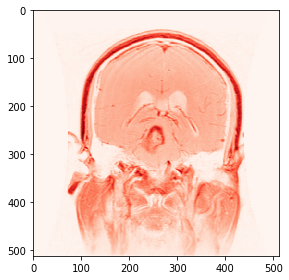

In [8]:
#Uncomment to verify contents of the directory loaded

""" directory contains the path of the image folder on the computer for running on Jupyter notebook when all files are in the same directory  
    drive_directory contains the path of the image folder on Google Drive for when Colab was being used for higher computational power.

    NOTE: As the order of the images was reshuffled when being uploaded to Google Drive due to internet speeds, we must use sorted() at the
    beginning of the for-loop when using dirpath otherwise the images will not be loaded in the order matching their corresponding labels. 
    Explicity this means when using Colab the for loop should read "for file in sorted(listdir(drive_directory))" instead of
    "for file in listdir(directory)".
    
    Change the name of the path in the for loop accordingly."""

directory = './dataset/image'
drive_directory = '/content/drive/MyDrive/Colab Notebooks/dataset/image'
#print(listdir(directory))
#print(listdir(drive_directory))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

images = [] #An empty list is created

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 23-25 and uncomment lines 27 and 28 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(drive_directory)):
    img = io.imread(drive_directory + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(images).shape) #Converting list images to a numpy array before outputting shape to verify 

### Splitting the data into training and testing data

In the cells below, we use train_test_split from the model_selection part of the sklearn package. This splits the data into training and testing data before we train the model. The testing data is left unseen so we can test our trained model using it.

In [9]:
X = np.array(images) #Set X to contain the extracted images, images must be in array from first
Y = tumour_labels['numeric label'] #Set Y to contain the corresponding numeric labels of each image

xTrain, xTest, yTrain, yTest = train_test_split(X,Y, random_state = 0) #Set random_state to 0 for reproducibility

print(xTrain.shape) #Printing the shape of xTrain to veryify data was split correctly and that xTrain is 2-dimensional as required for the learning model used (SVM)
print(xTest.shape) #Printing the shape of xTest to verify  data was split correctly and that xTest is 2-dimensional as required for the learning model used (SVM)

(2250, 512, 512)
(750, 512, 512)


### Feature Extraction using HOG - Histogram of Oriented Gradients

In the previous cell, we preprocess the image by potentially changing it a grayscale image. To further this preprocessing, we use a Historgram of Oriented Gradient. This is done using the hog function from scikit-image.

An HOG is needed as this extracts features from the image that a machine learning algorithm can better understand to increase the accuracy of training and any future predictions. 

It works by splitting the image into a grid of cells, and for the pixels in each cell, gradient directions are given as a histogram. These are then manipulated and the function outputs an HOG feature vector of features extracted from the image and an image to visualise the HOG image.

In [10]:
features_hog_train = [] #List to store the HOG feature vectors for each image
images_hog_train = [] #List to store the HOG image for each image

start_hog_train = datetime.now()

#Looping through all the images and performing hog() on them
for index in range(len(xTrain)):
    hog_feature, hog_image = hog(xTrain[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    features_hog_train.append(hog_feature) #Appending feature vector to a list storing them all
    images_hog_train.append(hog_image) #Appending HOG visualisation image to a list storing them all

end_hog_train = datetime.now()
time_hog_train = end_hog_train - start_hog_train
print('The time elapsed to complete the hog function on the training set is', time_hog_train)

The time elapsed to complete the hog function on the training set is 0:09:16.460233


In [11]:
features_hog_test = [] #List to store the HOG feature vectors for each image
images_hog_test = [] #List to store the HOG image for each image

start_hog_test = datetime.now()

#Looping through all the images and performing hog() on them
for index in range(len(xTest)):
    hog_feature, hog_image = hog(xTest[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    features_hog_test.append(hog_feature) #Appending feature vector to a list storing them all
    images_hog_test.append(hog_image) #Appending HOG visualisation image to a list storing them all

end_hog_test = datetime.now()
time_hog_test = end_hog_test - start_hog_test
print('The time elapsed to complete the hog function on the testing set is', time_hog_test)

The time elapsed to complete the hog function on the testing set is 0:03:05.154422


In [12]:
#Printing the shape of the features and images from the HOG function for verification

print(np.array(features_hog_train).shape)
print(np.array(images_hog_train).shape)

(2250, 72900)
(2250, 512, 512)


In [13]:
print(np.array(features_hog_test).shape)
print(np.array(images_hog_test).shape)

(750, 72900)
(750, 512, 512)


Text(0.5, 1.0, 'HOG Image (Testing)')

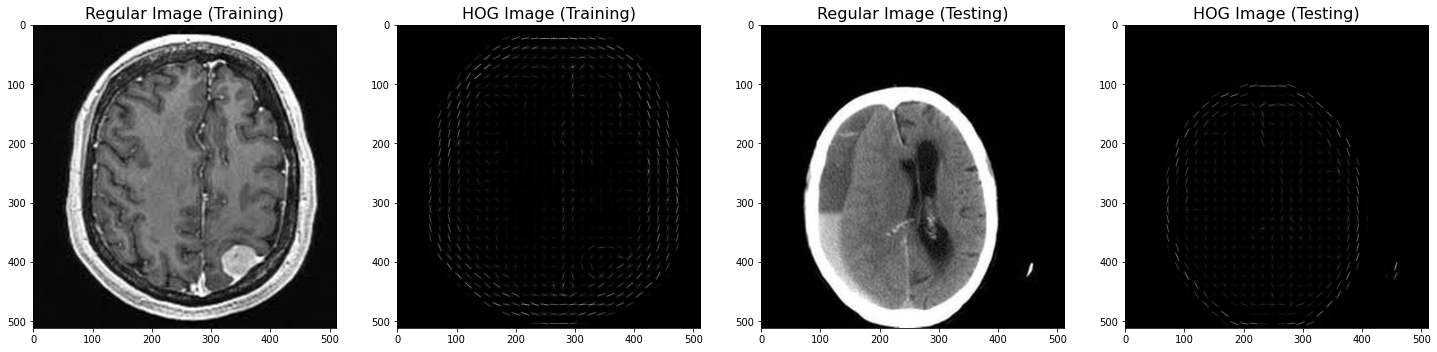

In [14]:
#This cell generates two plots side-by-side to image[45] (the same one printed after loading the images) before and after the HOG function to show what hog() does to the image

hog_vs_nohog, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,25))
ax[0].imshow(np.array(xTrain[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[0].set_title('Regular Image (Training)', fontsize = 16)
ax[1].imshow(np.array(images_hog_train[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[1].set_title('HOG Image (Training)', fontsize = 16)
ax[2].imshow(np.array(xTest[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[2].set_title('Regular Image (Testing)', fontsize = 16)
ax[3].imshow(np.array(images_hog_test[45]), cmap = 'gray') #A gray colormap is placed on the image
ax[3].set_title('HOG Image (Testing)', fontsize = 16)

In [15]:
feature_matrix_training = np.array(features_hog_train) #Converting the list of features extracted from HOG into an array
print(feature_matrix_training.shape) #Printing the shape of the feature matrix to visually verify if it is acceptable

(2250, 72900)


In [16]:
feature_matrix_testing = np.array(features_hog_test)
print(feature_matrix_testing.shape)

(750, 72900)


In [17]:
std_scl = StandardScaler()
feature_matrix_training = std_scl.fit_transform(feature_matrix_training)
feature_matrix_testing = std_scl.transform(feature_matrix_testing)

print(feature_matrix_training.shape)
print(feature_matrix_testing.shape)

(2250, 72900)
(750, 72900)


In [18]:
xTrain = feature_matrix_training
xTest = feature_matrix_testing

print(xTrain.shape)
print(xTest.shape)

(2250, 72900)
(750, 72900)


### PCA (Principle Component Analysis) for dimensionality reduction

We attempt to reduce the features per image in the cells below by running a PCA on them. PCA linearly transforms the data so most useful information is still contained in a smaller number of features.

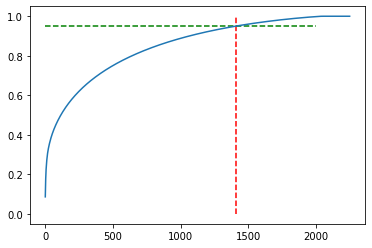

In [19]:
pca = PCA(random_state=0)
pca.fit(xTrain)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.vlines(x=1409, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=2000, xmin=0, colors="g", linestyles="--")
plt.plot(explained_variance)

In [20]:
pca_final = PCA(0.95, random_state = 0)
pca_xTrain = pca_final.fit_transform(xTrain)
pca_xTest = pca_final.transform(xTest)

print(pca_xTrain.shape)
print(pca_xTest.shape)

(2250, 1409)
(750, 1409)


### Training the models

In the following cells, we define the SVM model we are using by using the SVC() from sklearn. We then fit this to our Training set using xTrain and yTrain.

We initially test 3 models using 3 different kernel arguments (linear, poly and rbf). We also output the time taken for each model to train.

In [32]:
start_model1 = datetime.now()
model1_svmlinear = SVC(kernel='linear') 
model1_svmlinear.fit(pca_xTrain, yTrain) #Training the model by fitting it to our training data
end_model1 = datetime.now()
time_model1 = end_model1 - start_model1
print('The training time for Model 1 (SVM with Kernel = Linear) is: ', time_model1) 

The training time for Model 1 (SVM with Kernel = Linear) is:  0:00:01.448341


In [22]:
start_model2 = datetime.now()
model2_svmpoly = SVC(kernel = 'poly')
model2_svmpoly.fit(pca_xTrain, yTrain)
end_model2 = datetime.now()
time_model2 = end_model2 - start_model2
print('The training time for Model 2 (SVM with Kernel = Poly) is: ', time_model2)

The training time for Model 2 (SVM with Kernel = Poly) is:  0:00:03.516494


In [23]:
start_model3 = datetime.now()
model3_svmrbf = SVC(kernel = 'rbf')
model3_svmrbf.fit(pca_xTrain, yTrain)
end_model3 = datetime.now()
time_model3 = end_model3 - start_model3
print('The training time for Model 3 (SVM with Kernel = Rbf) is: ', time_model3)

The training time for Model 3 (SVM with Kernel = Rbf) is:  0:00:02.850790


In [24]:
start_model1_ovo = datetime.now()
model1_svmlinear_ovo = SVC(kernel='linear', decision_function_shape = 'ovo') 
model1_svmlinear_ovo.fit(pca_xTrain, yTrain) #Training the model by fitting it to our training data
end_model1_ovo = datetime.now()
time_model1_ovo = end_model1_ovo - start_model1_ovo
print('The training time for Model 1 (SVM with a Linear Kernel AND using the One-vs-One approach) is: ', time_model1_ovo) 

The training time for Model 1 (SVM with a Linear Kernel AND using the One-vs-One approach) is:  0:00:01.434491


In [27]:
start_model2_ovo = datetime.now()
model2_svmpoly_ovo = SVC(kernel='poly', decision_function_shape = 'ovo') 
model2_svmpoly_ovo.fit(pca_xTrain, yTrain) #Training the model by fitting it to our training data
end_model2_ovo = datetime.now()
time_model2_ovo = end_model2_ovo - start_model2_ovo
print('The training time for Model 2 (SVM with a Polynomial Kernel AND using the One-vs-One approach) is: ', time_model2_ovo) 

The training time for Model 2 (SVM with a Polynomial Kernel AND using the One-vs-One approach) is:  0:00:03.588689


In [28]:
start_model3_ovo = datetime.now()
model3_svmrbf_ovo = SVC(kernel='poly', decision_function_shape = 'ovo') 
model3_svmrbf_ovo.fit(pca_xTrain, yTrain) #Training the model by fitting it to our training data
end_model3_ovo = datetime.now()
time_model3_ovo = end_model3_ovo - start_model3_ovo
print('The training time for Model 3 (SVM with an RBF Kernel AND using the One-vs-One approach) is: ', time_model2_ovo) 

The training time for Model 3 (SVM with an RBF Kernel AND using the One-vs-One approach) is:  0:00:03.588689


## Predictions and Accuracy Metrics

In the following cells, we use .predict to generate to make predictions on our test data and store it in y_Pred which is then compared to yTest from the testing set to produce an accuracy score for the model as well as a classification report containing precision, recall and f1-scores. A confusion matrix is also generated for each model.

### Model 1 Prediction + Classification Report + Confusion Matrix

In [33]:
y_Pred_model1 = model1_svmlinear.predict(pca_xTest) #Making predictions on entire dataset using the model

In [34]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model1)))
print(classification_report(yTest,y_Pred_model1)) #The classification report shows classification metrics such as f1-score, precison, recall and accuracy scores

Accuracy on test set: 0.896
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       123
         1.0       0.96      0.97      0.96       202
         2.0       0.94      0.84      0.89       219
         3.0       0.80      0.90      0.85       206

    accuracy                           0.90       750
   macro avg       0.90      0.89      0.90       750
weighted avg       0.90      0.90      0.90       750



In [35]:
acc_model1 = model1_svmlinear.score(pca_xTest, yTest) #Accuracy score

In [36]:
cm_model1 = confusion_matrix(yTest, y_Pred_model1) #Confusion matrix generated

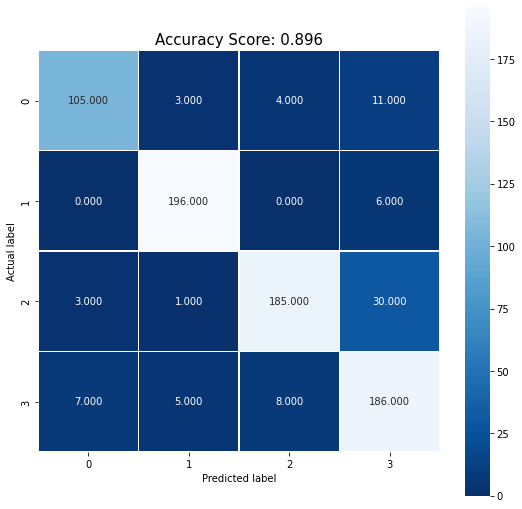

In [37]:
#The confusion matrix is plotted to visually show where the model performed best and worst in predicting the labels

plt.figure(figsize=(9,9))
sns.heatmap(cm_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model1)
plt.title(all_sample_title, size = 15);

### ROC Curves and AUC (Area under curve)

This calculates the receiver operating characteristic curve for the model. However, as this requires the probability to be set to true in the model (default is false) we have commented this section out. When probability is True, training time is tripled and so we only generated the ROC curve once and then commented out the cells. DO NOT USE UNCOMMENT THESE CELLS UNLESS YOU SET probability to probability = True IN THE SVM MODELS!

Tried only once as an example once and shows that the ROC is close to the top left corner which shows an excellent model as the AUC is 0.99 which is very close to 1.

ROC curves are good metrics but generally work better for binary classification as it would require a one-vs-rest or one-vs-one strategy and both take longer to train. 


In [30]:
#ROC Curves - only use when probability = True in model

#probabilities = model1_svmlinear.predict_proba(pca_xTest)
#y_probability = probabilities[:,1]
#false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_probability, pos_label=1)
#roc_auc = auc(false_positive_rate, true_positive_rate)

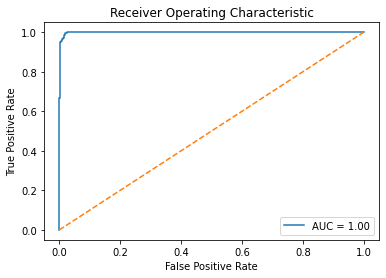

In [31]:
#plt.title('Receiver Operating Characteristic')
#plot the false positive rate on the x axis and the true positive rate on the y axis
#roc_plot = plt.plot(false_positive_rate,
 #                   true_positive_rate,
  #                  label='AUC = {:0.2f}'.format(roc_auc))

#plt.legend(loc=0)
#plt.plot([0,1], [0,1], ls='--')
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate');

### Model 2 Prediction + Classification Report + Confusion Matrix

In [38]:
y_Pred_model2 = model2_svmpoly.predict(pca_xTest)

In [39]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model2)))
print(classification_report(yTest,y_Pred_model2))

Accuracy on test set: 0.8586666666666667
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.78       123
         1.0       0.90      0.98      0.94       202
         2.0       0.91      0.83      0.87       219
         3.0       0.74      0.89      0.81       206

    accuracy                           0.86       750
   macro avg       0.88      0.84      0.85       750
weighted avg       0.87      0.86      0.86       750



In [40]:
acc_model2 = model2_svmpoly.score(pca_xTest, yTest)

In [41]:
cm_model2 = confusion_matrix(yTest, y_Pred_model2)

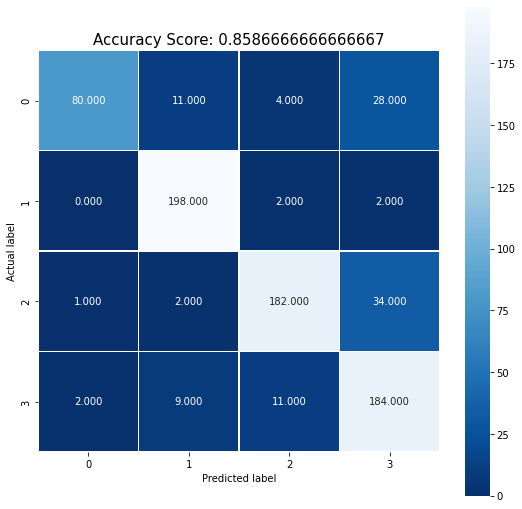

In [42]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model2)
plt.title(all_sample_title, size = 15);

### Model 3 Prediction + Classification Report + Confusion Matrix

In [43]:
y_Pred_model3 = model3_svmrbf.predict(pca_xTest)

In [44]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model3)))
print(classification_report(yTest,y_Pred_model3))

Accuracy on test set: 0.8453333333333334
              precision    recall  f1-score   support

         0.0       0.91      0.72      0.81       123
         1.0       0.84      0.99      0.90       202
         2.0       0.91      0.79      0.84       219
         3.0       0.78      0.84      0.81       206

    accuracy                           0.85       750
   macro avg       0.86      0.83      0.84       750
weighted avg       0.85      0.85      0.84       750



In [45]:
acc_model3 = model3_svmrbf.score(pca_xTest, yTest)

In [46]:
cm_model3 = confusion_matrix(yTest, y_Pred_model3)

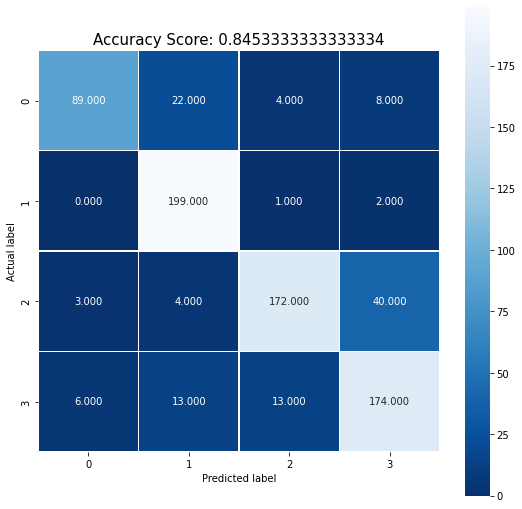

In [47]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model3)
plt.title(all_sample_title, size = 15);

### Model 1 (with OVO) Classification Report + Confusion Matrix

In [48]:
y_Pred_model1_ovo = model1_svmlinear_ovo.predict(pca_xTest) #Making predictions on entire dataset using the model

In [49]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model1_ovo)))
print(classification_report(yTest,y_Pred_model1_ovo)) #The classification report shows classification metrics such as f1-score, precison, recall and accuracy scores

Accuracy on test set: 0.896
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       123
         1.0       0.96      0.97      0.96       202
         2.0       0.94      0.84      0.89       219
         3.0       0.80      0.90      0.85       206

    accuracy                           0.90       750
   macro avg       0.90      0.89      0.90       750
weighted avg       0.90      0.90      0.90       750



In [50]:
acc_model1_ovo = model1_svmlinear_ovo.score(pca_xTest, yTest) #Accuracy score

In [51]:
cm_model1_ovo = confusion_matrix(yTest, y_Pred_model1_ovo) #Confusion matrix generated

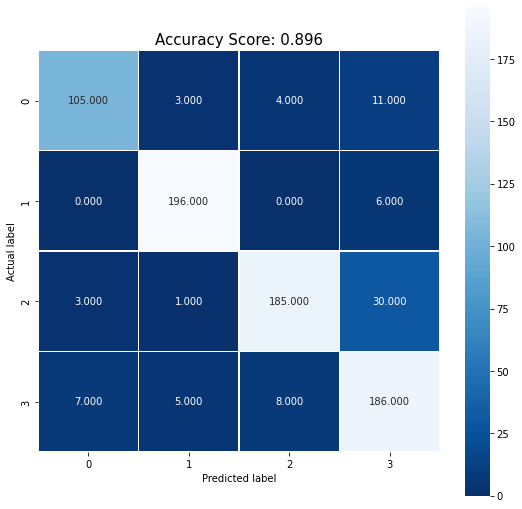

In [52]:
#The confusion matrix is plotted to visually show where the model performed best and worst in predicting the labels

plt.figure(figsize=(9,9))
sns.heatmap(cm_model1_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model1_ovo)
plt.title(all_sample_title, size = 15);

### Model 2 (with OVO) Classification Report + Confusion Matrix

In [53]:
y_Pred_model2_ovo = model2_svmpoly_ovo.predict(pca_xTest) #Making predictions on entire dataset using the model

In [54]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model2_ovo)))
print(classification_report(yTest,y_Pred_model2_ovo)) #The classification report shows classification metrics such as f1-score, precison, recall and accuracy scores

Accuracy on test set: 0.8586666666666667
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.78       123
         1.0       0.90      0.98      0.94       202
         2.0       0.91      0.83      0.87       219
         3.0       0.74      0.89      0.81       206

    accuracy                           0.86       750
   macro avg       0.88      0.84      0.85       750
weighted avg       0.87      0.86      0.86       750



In [55]:
acc_model2_ovo = model2_svmpoly_ovo.score(pca_xTest, yTest) #Accuracy score

In [56]:
cm_model2_ovo = confusion_matrix(yTest, y_Pred_model2_ovo) #Confusion matrix generated

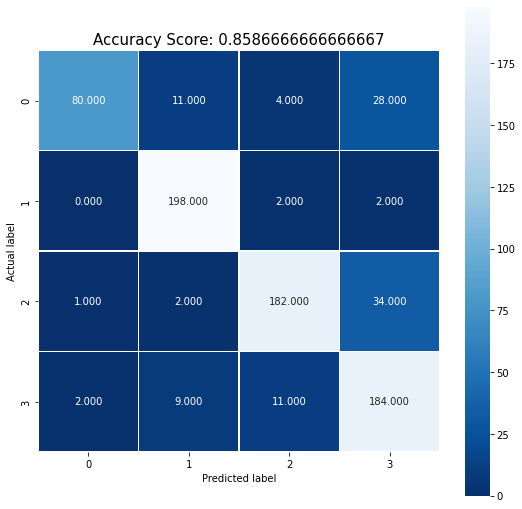

In [57]:
#The confusion matrix is plotted to visually show where the model performed best and worst in predicting the labels

plt.figure(figsize=(9,9))
sns.heatmap(cm_model2_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model2_ovo)
plt.title(all_sample_title, size = 15);

### Model 3 (with OVO) Classification Report + Confusion Matrix

In [58]:
y_Pred_model3_ovo = model3_svmrbf_ovo.predict(pca_xTest) #Making predictions on entire dataset using the model

In [59]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model3_ovo)))
print(classification_report(yTest,y_Pred_model3_ovo)) #The classification report shows classification metrics such as f1-score, precison, recall and accuracy scores

Accuracy on test set: 0.8586666666666667
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.78       123
         1.0       0.90      0.98      0.94       202
         2.0       0.91      0.83      0.87       219
         3.0       0.74      0.89      0.81       206

    accuracy                           0.86       750
   macro avg       0.88      0.84      0.85       750
weighted avg       0.87      0.86      0.86       750



In [60]:
acc_model3_ovo = model3_svmrbf_ovo.score(pca_xTest, yTest) #Accuracy score

In [61]:
cm_model3_ovo = confusion_matrix(yTest, y_Pred_model3_ovo) #Confusion matrix generated

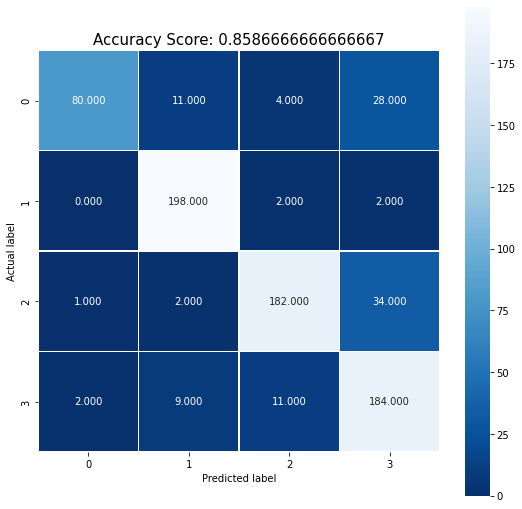

In [62]:
#The confusion matrix is plotted to visually show where the model performed best and worst in predicting the labels

plt.figure(figsize=(9,9))
sns.heatmap(cm_model3_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model3_ovo)
plt.title(all_sample_title, size = 15);

## Learning Curves 

### Learning Curves for models using the OvR approach

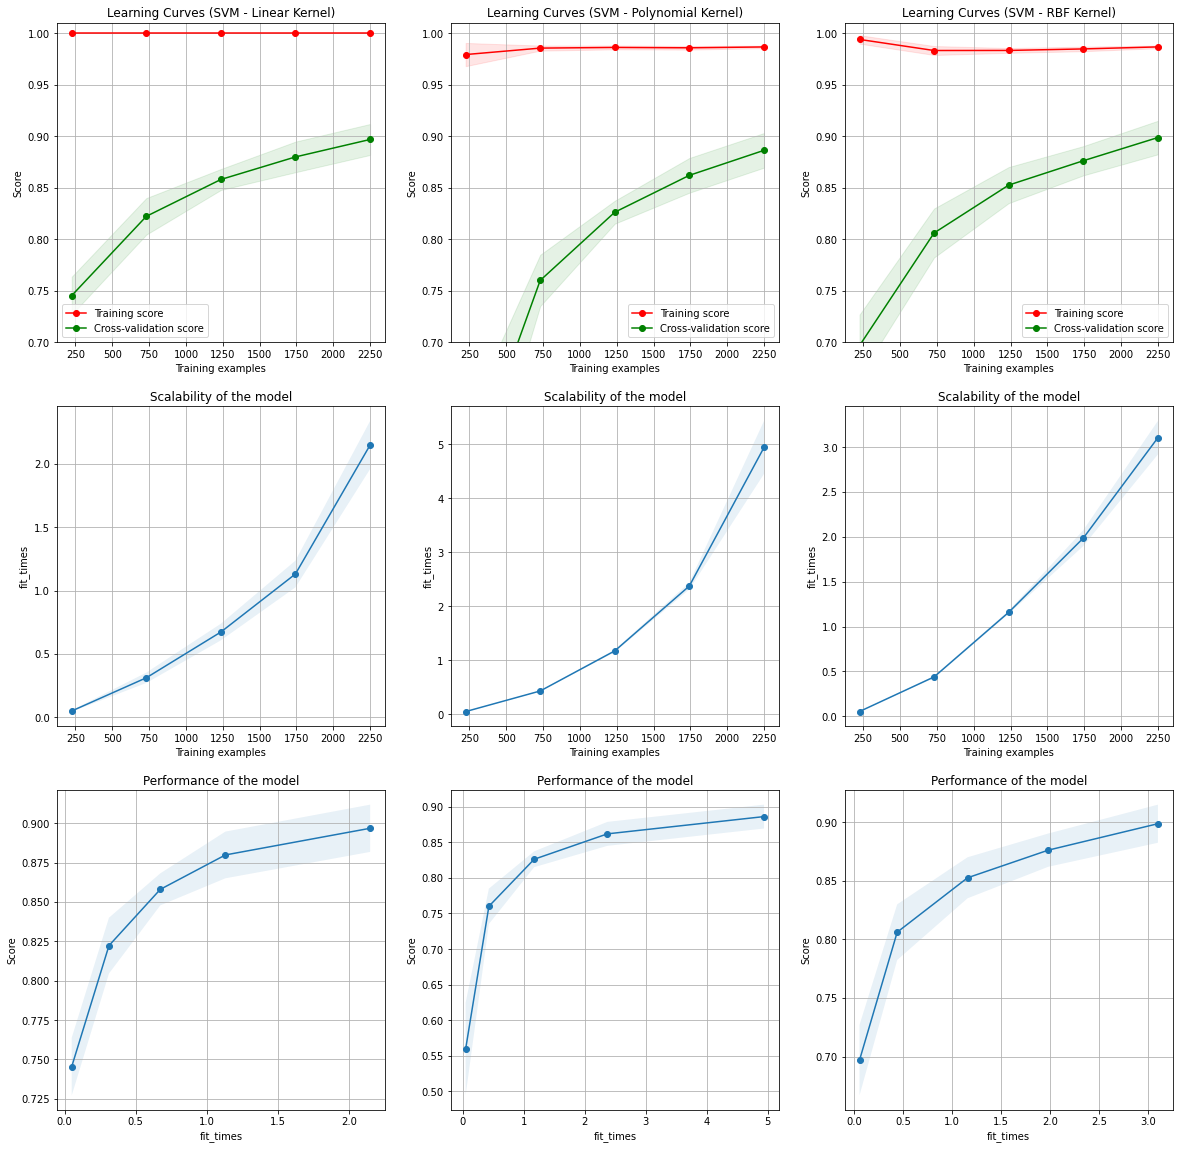

In [63]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(20, 20))

xLearningCurve = np.concatenate([pca_xTrain, pca_xTest])
yLearningCurve = np.concatenate([yTrain, yTest])

title = r"Learning Curves (SVM - Linear Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model1_svmlinear
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM - Polynomial Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model2_svmpoly
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM - RBF Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model3_svmrbf
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

### Learning curves using the OVO approach

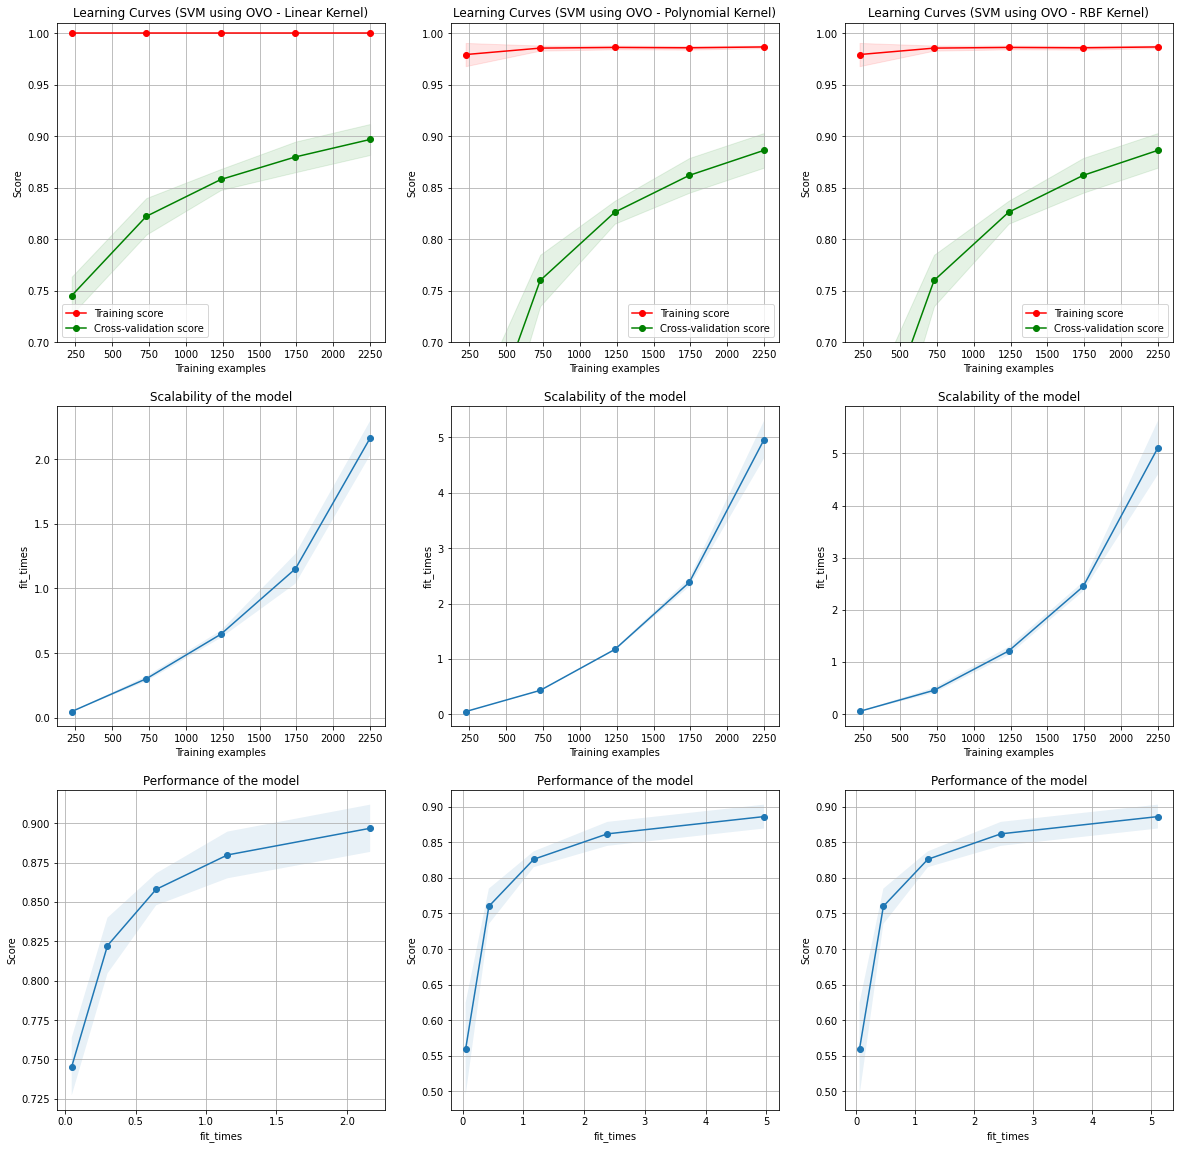

In [64]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(20, 20))

xLearningCurve = np.concatenate([pca_xTrain, pca_xTest])
yLearningCurve = np.concatenate([yTrain, yTest])

title = r"Learning Curves (SVM using OVO - Linear Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model1_svmlinear_ovo
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM using OVO - Polynomial Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model2_svmpoly_ovo
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)


title = r"Learning Curves (SVM using OVO - RBF Kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
estimator = model3_svmrbf_ovo
plot_learning_curve(
    estimator, title, xLearningCurve, yLearningCurve, axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

### Hyperparameter Tuning using GridsearchCV

The hyperparameters of our model cannot be directly learned and so this gridsearch function tries a combination of all the parameters from the parameter grid defined below and the best combination with the highest accuracy score is determined.

This best combination is output to show our model after hyperparameter tuning and this model is then used to redo our predictions to see how much the predictions had improved by.

In [107]:
#Defining the parameter grid containing the different values we want to test for each parameter

param_grid = param_grid = {'C': [0.1, 1, 10, 100], 

              'gamma': [1, 0.1, 0.01],

              'decision_function_shape': ['ovr', 'ovo'],

              'kernel': ['linear', 'rbf', 'poly']} 
 
start_tune = datetime.now()
gridSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
#Fitting the model for a gridsearch which goes the all the possible combinations of data
gridSVM.fit(pca_xTrain, yTrain)
end_tune = datetime.now()
time_tune = end_tune - start_tune
print('The time taken for Hyperparameter Tuning is: ', time_tune)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=linear;, score=0.893 total time=   1.4s
[CV 2/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=linear;, score=0.927 total time=   1.5s
[CV 3/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=linear;, score=0.913 total time=   1.5s
[CV 4/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=linear;, score=0.896 total time=   1.5s
[CV 5/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=linear;, score=0.911 total time=   1.5s
[CV 1/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.287 total time=   3.3s
[CV 2/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.289 total time=   3.3s
[CV 3/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.289 total time=   3.3s
[CV 4/5] END C=0.1, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.289 total time=   3.2s
[CV 5

In [108]:
print(gridSVM.best_params_)
print(gridSVM.best_estimator_)

{'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')


In [109]:
tuned_predictions = gridSVM.predict(pca_xTest)
print('Accuracy on test set: '+str(accuracy_score(yTest,tuned_predictions)))
print(classification_report(yTest, tuned_predictions))

Accuracy on test set: 0.896
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       123
         1.0       0.96      0.97      0.96       202
         2.0       0.94      0.84      0.89       219
         3.0       0.80      0.90      0.85       206

    accuracy                           0.90       750
   macro avg       0.90      0.89      0.90       750
weighted avg       0.90      0.90      0.90       750



In [110]:
acc_tunedmodel = gridSVM.score(pca_xTest, yTest)

In [111]:
cm_tunedmodel = confusion_matrix(yTest, tuned_predictions)

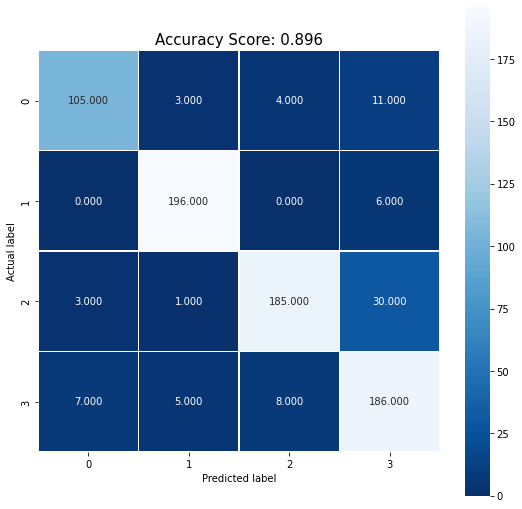

In [112]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_tunedmodel, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_tunedmodel)
plt.title(all_sample_title, size = 15);

### Testing and reporting new accuracy score using updated test set 

In the following cells we use similar methods to the ones we had above to load the images from the new test set uploaded recently. 

We then carry out identical preprocessing techniques to those we did above and those were HOG followed by PCA. 

However, as the models are already trained and the entire dataset will be used for testing, we do not need to split the data nor retrain the model and instead we immediately test the new data.

In [65]:
#Two different paths given: top line is for using Google Drive with Colab and bottom is for in all other situations. Comment and uncomment accordingly.

new_tumour_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test/label.csv')
#new_tumour_labels = pd.read_csv('./test/label.csv')

print(new_tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(200, 2)


In [66]:
new_tumour_labels

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,meningioma_tumor
2,IMAGE_0002.jpg,glioma_tumor
3,IMAGE_0003.jpg,pituitary_tumor
4,IMAGE_0004.jpg,glioma_tumor
...,...,...
195,IMAGE_0195.jpg,pituitary_tumor
196,IMAGE_0196.jpg,no_tumor
197,IMAGE_0197.jpg,meningioma_tumor
198,IMAGE_0198.jpg,no_tumor


In [67]:
for CLASS in classes:
    new_tumour_labels.loc[new_tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [68]:
new_tumour_labels

,file_name,label,numeric label
0,IMAGE_0000.jpg,meningioma_tumor,3.0
1,IMAGE_0001.jpg,meningioma_tumor,3.0
2,IMAGE_0002.jpg,glioma_tumor,2.0
3,IMAGE_0003.jpg,pituitary_tumor,1.0
4,IMAGE_0004.jpg,glioma_tumor,2.0
...,...,...,...
195,IMAGE_0195.jpg,pituitary_tumor,1.0
196,IMAGE_0196.jpg,no_tumor,0.0
197,IMAGE_0197.jpg,meningioma_tumor,3.0
198,IMAGE_0198.jpg,no_tumor,0.0


The time elapsed to load the images was:  0:00:04.360534
(200, 512, 512)


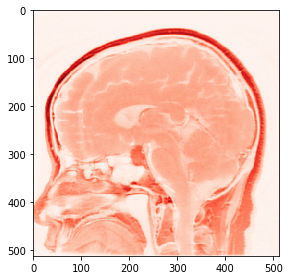

In [69]:
#Uncomment to verify contents of the directory loaded

""" directoryNEW contains the path of the image folder of the new test set on the computer for running on Jupyter notebook when all files are in the same directory  
    drive_directoryNEW contains the path of the image folder of the new test set on Google Drive for when Colab was being used for higher computational power.

    NOTE: As the order of the images was reshuffled when being uploaded to Google Drive due to internet speeds, we must use sorted() at the
    beginning of the for-loop when using dirpath otherwise the images will not be loaded in the order matching their corresponding labels. 
    Explicity this means when using Colab the for loop should read "for file in sorted(listdir(drive_directory))" instead of
    "for file in listdir(directory)".
    
    Change the name of the path in the for loop accordingly."""

#Defines the directory name and stores it in dirname
drive_directoryNEW = '/content/drive/MyDrive/Colab Notebooks/test/image'
directoryNEW = './test/image'
#print(listdir(dirname))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

validation_images = [] #An empty list is created to store the images from the new test set uploaded most recently 

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 23-25 and uncomment lines 27 and 28 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(drive_directoryNEW)):
    img = io.imread(drive_directoryNEW + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    validation_images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(validation_images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(validation_images).shape) #Converting list images to a numpy array before outputting shape to verify 

Identical preprocessing techniques including HOG and PCA are carried out for feature extraction before then testing the data

In [70]:
xVal = np.array(validation_images)
yVal = new_tumour_labels['numeric label']

print(xVal.shape) #We print the shape of x_val to ensure the features in the testing set are of the quantity expected


(200, 512, 512)


In [71]:
validation_features_hog = []
validation_images_hog = []

for index in range(len(xVal)):
    hog_feature_val, hog_image_val = hog(xVal[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    validation_features_hog.append(hog_feature_val)
    validation_images_hog.append(hog_image_val)


In [72]:
print(np.array(validation_features_hog).shape)
print(np.array(validation_images_hog).shape)

(200, 72900)
(200, 512, 512)


In [73]:
validation_feature_matrix = np.array(validation_features_hog)
print(validation_feature_matrix.shape)

(200, 72900)


In [74]:
validation_feature_matrix = std_scl.transform(validation_feature_matrix)
print(validation_feature_matrix.shape)

(200, 72900)


In [75]:
pca_xVal = pca_final.transform(validation_feature_matrix)

In [76]:
print(pca_xVal.shape)

(200, 1409)


All the test data is used as a testing set and hence we do not split the data. Rather, we name it with "val" to indicate the new data is being used to validate that the model previously trained will work on unseen data.

## MODEL 1

In [77]:
y_val_Pred_model1 = model1_svmlinear.predict(pca_xVal)

In [78]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model1)))
print(classification_report(yVal,y_val_Pred_model1)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.895
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        37
         1.0       0.91      0.98      0.94        52
         2.0       0.90      0.81      0.85        43
         3.0       0.88      0.88      0.88        68

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200



In [79]:
acc_new_model1 = model1_svmlinear.score(pca_xVal, yVal)

In [80]:
new_cm_model1 = confusion_matrix(yVal, y_val_Pred_model1)

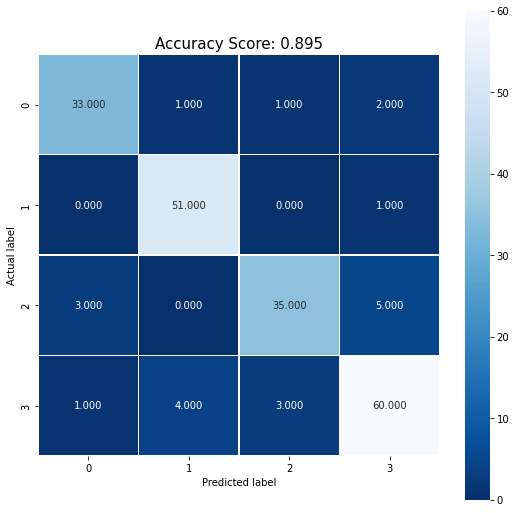

In [81]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model1)
plt.title(all_sample_title, size = 15);

## MODEL 2

In [82]:
y_val_Pred_model2 = model2_svmpoly.predict(pca_xVal)

In [83]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model2)))
print(classification_report(yVal,y_val_Pred_model2)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.855
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.77        37
         1.0       0.86      0.98      0.92        52
         2.0       0.93      0.86      0.89        43
         3.0       0.78      0.87      0.82        68

    accuracy                           0.85       200
   macro avg       0.88      0.84      0.85       200
weighted avg       0.87      0.85      0.85       200



In [84]:
acc_new_model2 = model2_svmpoly.score(pca_xVal, yVal)

In [85]:
new_cm_model2 = confusion_matrix(yVal, y_val_Pred_model2)

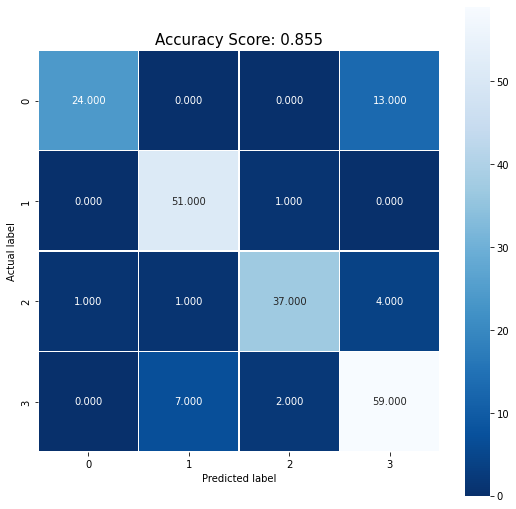

In [86]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model2)
plt.title(all_sample_title, size = 15);

## MODEL 3

In [87]:
y_val_Pred_model3 = model3_svmrbf.predict(pca_xVal)

In [88]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model3)))
print(classification_report(yVal,y_val_Pred_model3)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.835
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87        37
         1.0       0.75      0.98      0.85        52
         2.0       0.82      0.84      0.83        43
         3.0       0.91      0.72      0.80        68

    accuracy                           0.83       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.83      0.83       200



In [89]:
acc_new_model3 = model3_svmrbf.score(pca_xVal, yVal)

In [90]:
new_cm_model3 = confusion_matrix(yVal, y_val_Pred_model3)

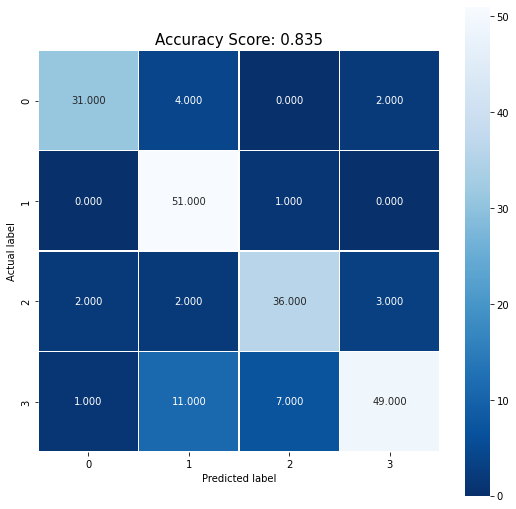

In [91]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model3)
plt.title(all_sample_title, size = 15);

## MODEL 1

In [92]:
y_val_Pred_model1_ovo = model1_svmlinear_ovo.predict(pca_xVal)

In [93]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model1_ovo)))
print(classification_report(yVal,y_val_Pred_model1_ovo)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.895
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        37
         1.0       0.91      0.98      0.94        52
         2.0       0.90      0.81      0.85        43
         3.0       0.88      0.88      0.88        68

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200



In [94]:
acc_new_model1_ovo = model1_svmlinear_ovo.score(pca_xVal, yVal)

In [95]:
new_cm_model1_ovo = confusion_matrix(yVal, y_val_Pred_model1_ovo)

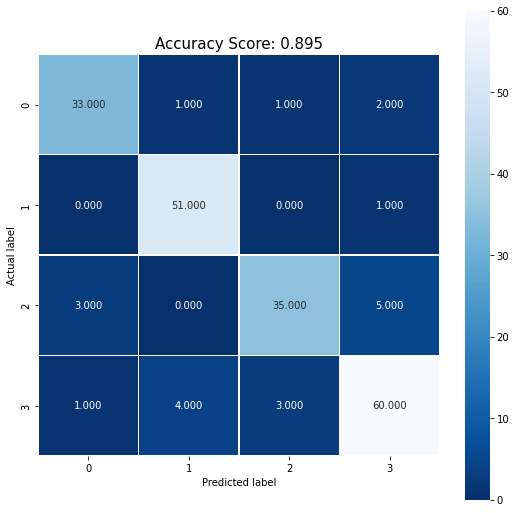

In [96]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model1_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model1_ovo)
plt.title(all_sample_title, size = 15);

## MODEL 2

In [97]:
y_val_Pred_model2_ovo = model2_svmpoly_ovo.predict(pca_xVal)

In [98]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model2_ovo)))
print(classification_report(yVal,y_val_Pred_model2_ovo)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.855
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.77        37
         1.0       0.86      0.98      0.92        52
         2.0       0.93      0.86      0.89        43
         3.0       0.78      0.87      0.82        68

    accuracy                           0.85       200
   macro avg       0.88      0.84      0.85       200
weighted avg       0.87      0.85      0.85       200



In [99]:
acc_new_model2_ovo = model2_svmpoly_ovo.score(pca_xVal, yVal)

In [100]:
new_cm_model2_ovo = confusion_matrix(yVal, y_val_Pred_model2_ovo)

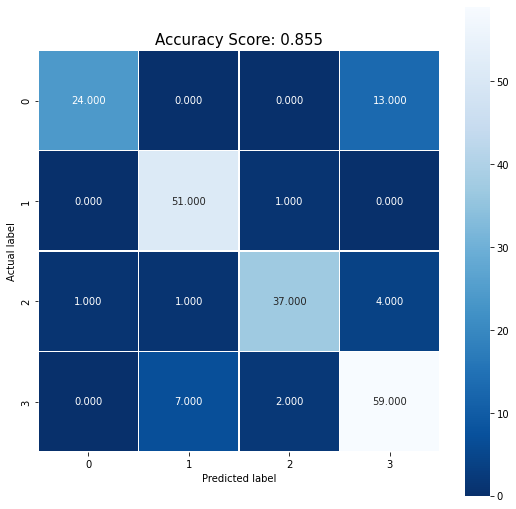

In [101]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model2_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model2_ovo)
plt.title(all_sample_title, size = 15);

## MODEL 3

In [102]:
y_val_Pred_model3_ovo = model3_svmrbf_ovo.predict(pca_xVal)

In [103]:
print('Accuracy on new validation set: '+str(accuracy_score(yVal,y_val_Pred_model3_ovo)))
print(classification_report(yVal,y_val_Pred_model3_ovo)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.855
              precision    recall  f1-score   support

         0.0       0.96      0.65      0.77        37
         1.0       0.86      0.98      0.92        52
         2.0       0.93      0.86      0.89        43
         3.0       0.78      0.87      0.82        68

    accuracy                           0.85       200
   macro avg       0.88      0.84      0.85       200
weighted avg       0.87      0.85      0.85       200



In [104]:
acc_new_model3_ovo = model3_svmrbf_ovo.score(pca_xVal, yVal)

In [105]:
new_cm_model3_ovo = confusion_matrix(yVal, y_val_Pred_model3_ovo)

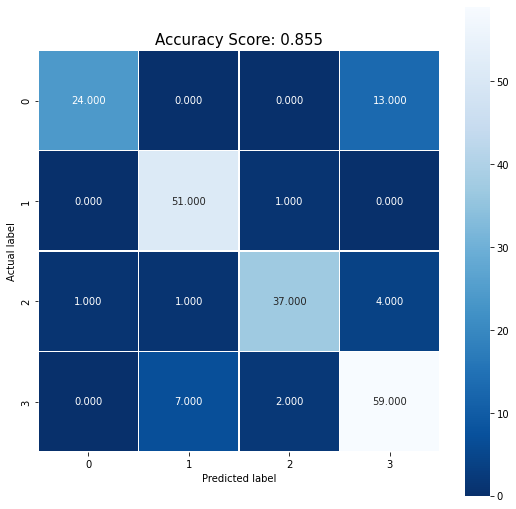

In [106]:
plt.figure(figsize=(9,9))
sns.heatmap(new_cm_model3_ovo, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model3_ovo)
plt.title(all_sample_title, size = 15);

### Results on new test test using the model with hypertuned parameters

In [113]:
tuned_predictions_newset = gridSVM.predict(pca_xVal)
print('Accuracy on test set: '+str(accuracy_score(yVal,tuned_predictions_newset)))
print(classification_report(yVal,tuned_predictions_newset))

Accuracy on test set: 0.895
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        37
         1.0       0.91      0.98      0.94        52
         2.0       0.90      0.81      0.85        43
         3.0       0.88      0.88      0.88        68

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200



In [114]:
acc_tunedmodel_newset = gridSVM.score(pca_xVal, yVal)

In [115]:
cm_tunedmodel_newset = confusion_matrix(yVal, tuned_predictions_newset)

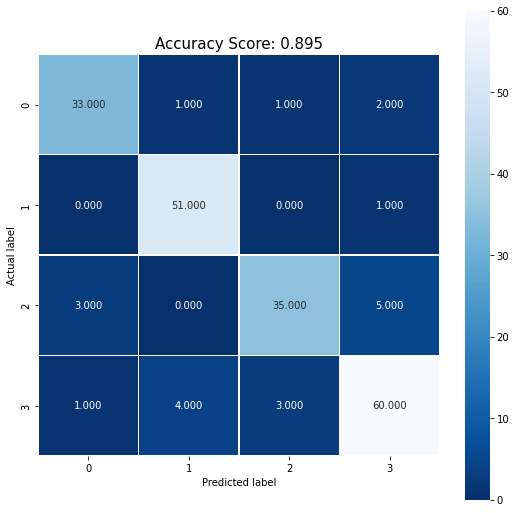

In [116]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_tunedmodel_newset, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_tunedmodel_newset)
plt.title(all_sample_title, size = 15);

In [117]:
taskB_end = datetime.now()
taskB_time = taskB_end - taskB_start
print('The time taken for this script is: ', taskB_time)

The time taken for this script is:  0:47:13.998244
